## Static dataset creation
This notebook walks through how to use the modules to create and save a static dataset for use in all of the statistical and ML methods. The method-focused notebooks show how to import and utilize this static dataset in inference.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts.io import DataLoader, DataPreparation

Use the `DataPreparation()` class from `io` to simulate some linear data with two levels of noise.

Low noise is $\sigma = 1$. High noise is $\sigma = 10$. Both use the same input xs and same priors. Let's simulate the low noise first.

In [2]:
data = DataPreparation()

In [3]:
data.sample_params_from_prior(10000)

In [4]:
sigma = 10
data.simulate_data(data.params,
                   sigma, 
                   'linear_homogeneous'
                    )

Linear simulation data generated.


Let's take a look at this simulated dataset.

In [5]:
print(np.shape(data.output[0]))
data.output

torch.Size([101])


tensor([[ -0.9502,   5.7472,  24.0461,  ..., 419.0801, 406.7336, 427.8695],
        [ 10.9524,   4.4689,  15.0456,  ..., 531.7468, 553.5215, 574.1509],
        [  4.2659,  22.7429,  39.8520,  ..., 729.7822, 768.7776, 759.2146],
        ...,
        [ -6.3480,  12.2626,   8.6947,  ..., 346.5633, 346.4275, 328.5460],
        [ 23.7462,  22.2628,   4.1576,  ..., 529.5311, 530.8721, 520.3676],
        [ 13.0244,  10.0619,  15.9999,  ..., 416.1508, 450.6803, 427.7013]])

In [6]:
data.params

tensor([[ 4.2016,  6.1737],
        [ 5.4770,  3.4147],
        [ 7.6029,  4.7109],
        ...,
        [ 3.3810,  1.2021],
        [ 5.3220,  7.3427],
        [ 4.4231, -1.4793]])

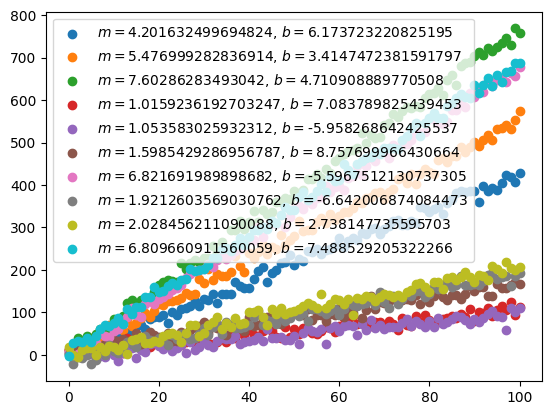

In [7]:
plt.clf()
for i in range(10):
    plt.scatter(data.input, data.output[i],
                label = f'$m = ${data.params[i][0].numpy()}, $b = ${data.params[i][1].numpy()}')
plt.legend()
plt.show()
    

In [8]:
# now make it into a dataframe
dict = data.get_dict()
dict

{'params': tensor([[ 4.2016,  6.1737],
         [ 5.4770,  3.4147],
         [ 7.6029,  4.7109],
         ...,
         [ 3.3810,  1.2021],
         [ 5.3220,  7.3427],
         [ 4.4231, -1.4793]]),
 'inputs': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100.]),
 'output': tensor([[ -0.9502,   5.7472,  24.0461,  ..., 419.0801, 406.7336, 427.8695],
         [ 10.9

## Save the data to h5

In [9]:
saver = DataLoader()

In [10]:
# save the dataframe
filepath = '../data/'
saver.save_data_h5('linear_sigma_'+str(sigma), dict)